In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from pydub import AudioSegment

SAMPLE_RATE = 22050
MAX_DURATION = 3  # in seconds
MAX_LENGTH = SAMPLE_RATE * MAX_DURATION

In [2]:
# Step 2: Convert .flac to .wav (if needed) and Extract Mel Spectrograms
def convert_flac_to_wav(flac_path):
    audio = AudioSegment.from_file(flac_path, format='flac')
    wav_path = flac_path.replace('.flac', '.wav')
    audio.export(wav_path, format='wav')
    return wav_path

def extract_features(file_path):
    if file_path.endswith('.flac'):
        file_path = convert_flac_to_wav(file_path)

    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(signal) > MAX_LENGTH:
        signal = signal[:MAX_LENGTH]
    else:
        pad_width = MAX_LENGTH - len(signal)
        signal = np.pad(signal, (0, pad_width))

    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [4]:
!unzip /content/voice_dataset.zip

Archive:  /content/voice_dataset.zip
replace voice_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: voice_dataset/.DS_Store  
replace __MACOSX/voice_dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/voice_dataset/._.DS_Store  
replace voice_dataset/male/5694_5694-64038-0008.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import os

male_dir = '/content/voice_dataset/male'
female_dir = '/content/voice_dataset/female'

num_male_files = len([f for f in os.listdir(male_dir) if os.path.isfile(os.path.join(male_dir, f))])
num_female_files = len([f for f in os.listdir(female_dir) if os.path.isfile(os.path.join(female_dir, f))])

print(f"Number of files in the 'male' folder: {num_male_files}")
print(f"Number of files in the 'female' folder: {num_female_files}")

Number of files in the 'male' folder: 1000
Number of files in the 'female' folder: 1000


In [7]:
AUDIO_PATH ="/content/voice_dataset"

In [15]:
X1 = []
y1 = []

X = []
y = []

for label in ['male', 'female']:
    folder = os.path.join(AUDIO_PATH, label)
    for file in tqdm(os.listdir(folder), desc=f"Processing {label}"):
        file_path = os.path.join(folder, file)
        try:
            features = extract_features(file_path)
            X1.append(features)
            y1.append(label)
        except Exception as e:
            print(f"Failed to process {file_path}: {e}")

# X = np.array(X)
# X = X[..., np.newaxis]  # shape: (samples, height, width, 1)

# Encode and one-hot labels
X = np.array(X1)
le = LabelEncoder()
y_encoded = le.fit_transform(y1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Processing female: 100%|██████████| 1000/1000 [00:19<00:00, 50.05it/s]


#Baseline model RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Reshape X_train and X_test to 2D for RandomForest
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_2d, y_train)

Evaluation
y_pred = clf.predict(X_test_2d)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:

              precision    recall  f1-score   support

      female       0.95      0.95      0.95       201
        male       0.95      0.94      0.95       199

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



Advanced Models : CNN 1D

In [18]:
 #Feature Extraction (MFCC with time dimension)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc.T  # shape: (time_steps, n_mfcc)


In [ ]:
X = []
y = []

for gender in ['male', 'female']:
    folder = os.path.join(AUDIO_PATH, gender)
    for fname in tqdm(os.listdir(folder), desc=f"Extracting features for {gender}" ):
        try:
            path = os.path.join(folder, fname)
            features = extract_features(path)
            if features.shape[0] >= 100:
                features = features[:100, :]  # Ensure fixed length
            else:
                pad_width = 100 - features.shape[0]
                features = np.pad(features, ((0, pad_width), (0, 0)))
            X.append(features)
            y.append(gender)
        except Exception as e:
            print(f"Error extracting features from {fname}: {e}")

X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)



In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical


# Step 8: 1D CNN Model
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Step 9: Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Step 10: Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       180,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,138 (918.51 KB)

 Trainable params: 234,754 (917.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7462 - loss: 0.7422 - val_accuracy: 0.9406 - val_loss: 0.1461
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9712 - loss: 0.0698 - val_accuracy: 0.9062 - val_loss: 0.2844
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9816 - loss: 0.0563 - val_accuracy: 0.9688 - val_loss: 0.0967
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9822 - loss: 0.0410 - val_accuracy: 0.9812 - val_loss: 0.0504
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9980 - loss: 0.0133 - val_accuracy: 0.9781 - val_loss: 0.0406
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9932 - loss: 0.0152 - val_accuracy: 0.9781 - val_loss: 0.0488
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9952 - loss: 0.0120 - val_accuracy: 0.9906 - val_loss: 0.0389
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9911 - loss: 0.0300 - val_accuracy: 0.9750 - v

#Advanced Model LSTM + CNN hybrid model


In [22]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Step 9: Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Step 10: Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 96, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,802 (237.51 KB)

 Trainable params: 60,674 (237.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.7092 - loss: 0.5213 - val_accuracy: 0.9781 - val_loss: 0.0802
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9654 - loss: 0.1260 - val_accuracy: 0.8906 - val_loss: 0.3120
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9909 - loss: 0.0559 - val_accuracy: 0.9375 - val_loss: 0.2440
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9805 - loss: 0.0604 - val_accuracy: 0.9500 - val_loss: 0.1260
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9851 - loss: 0.0662 - val_accuracy: 0.9688 - val_loss: 0.1441
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9946 - loss: 0.0179 - val_accuracy: 0.9969 - val_loss: 0.0062
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9969 - val_loss: 0.0206
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9946 - loss: 0.0233 - val_accuracy: 1.0000 - v

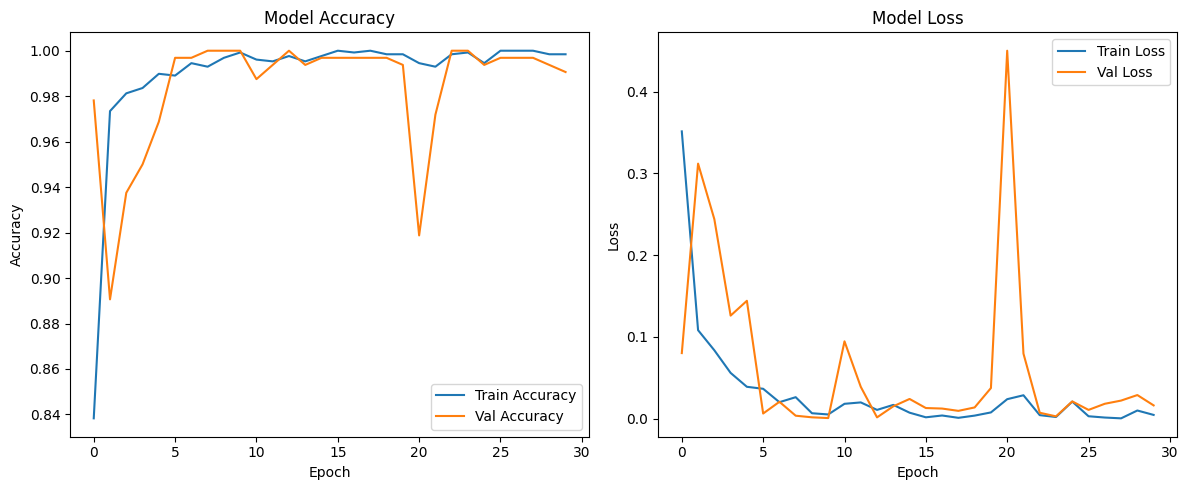

In [23]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


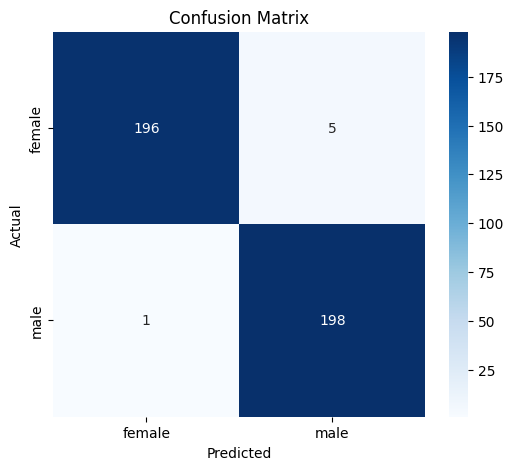

In [24]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
labels = le.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Experiment with raw waveform input instead of MFCC or Mel spectrograms

In [25]:
#Experiment with raw waveform input instead of MFCC or Mel spectrograms

In [26]:
#Feature Extraction (Raw waveform with fixed-length)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    target_length = sr * 3  # 3 seconds
    if len(y) > target_length:
        y = y[:target_length]
    else:
        y = np.pad(y, (0, target_length - len(y)))
    return y.reshape(-1, 1)  # reshape for Conv1D input


In [28]:
X = []
y = []

for gender in ['male', 'female']:
    folder = os.path.join(AUDIO_PATH, gender)
    for fname in tqdm(os.listdir(folder), desc=f"Extracting features for {gender}" ):
        try:
            path = os.path.join(folder, fname)
            features = extract_features(path)
            if features.shape[0] >= 100:
                features = features[:100, :]  # Ensure fixed length
            else:
                pad_width = 100 - features.shape[0]
                features = np.pad(features, ((0, pad_width), (0, 0)))
            X.append(features)
            y.append(gender)
        except Exception as e:
            print(f"Error extracting features from {fname}: {e}")

X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

Extracting features for female: 100%|██████████| 1000/1000 [00:02<00:00, 499.79it/s]


In [29]:
# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Step 8: Simple 1D CNN on Raw Audio
model = Sequential()
model.add(Conv1D(64, kernel_size=9, activation='relu', input_shape=(X.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=9, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Step 9: Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 92, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 92, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 38, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 38, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       155,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,106 (902.76 KB)

 Trainable params: 230,722 (901.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5697 - loss: 0.7268 - val_accuracy: 0.4563 - val_loss: 0.7002
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5833 - loss: 0.6658 - val_accuracy: 0.4563 - val_loss: 0.7005
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5948 - loss: 0.6574 - val_accuracy: 0.4563 - val_loss: 0.6981
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6067 - loss: 0.6660 - val_accuracy: 0.4563 - val_loss: 0.6984
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6520 - loss: 0.6377 - val_accuracy: 0.4563 - val_loss: 0.7055
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6458 - loss: 0.6243 - val_accuracy: 0.4563 - val_loss: 0.7046
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6396 - loss: 0.6294 - val_accuracy: 0.4563 - val_loss: 0.7067
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6829 - loss: 0.5870 - val_accuracy: 0.4563 - v

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6319 - loss: 1.6327


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


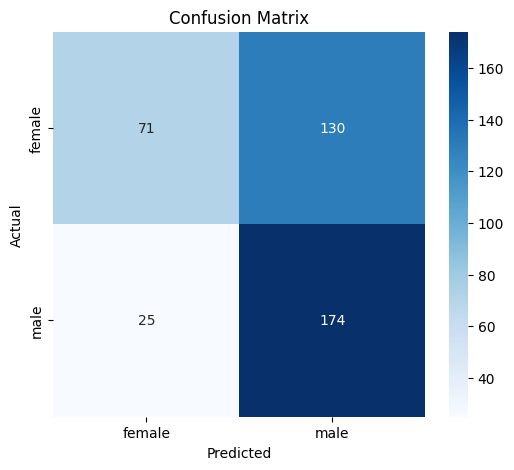

              precision    recall  f1-score   support

      female       0.74      0.35      0.48       201
        male       0.57      0.87      0.69       199

    accuracy                           0.61       400
   macro avg       0.66      0.61      0.58       400
weighted avg       0.66      0.61      0.58       400

Test Accuracy: 0.61


In [32]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
labels = le.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))
print(f"Test Accuracy: {accuracy:.2f}")
